In [1]:
import numpy as np 
np.set_printoptions(precision=4)
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm
from scipy.special import j1
import matplotlib.pyplot as plt
import matplotlib as mpl
import infomeasure as im

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['legend.fontsize'] = 15

In [2]:
def sample_from_pdf_2d(pdf, x_bounds, y_bounds, n_samples):
    samples = []
    xmin, xmax = x_bounds
    ymin, ymax = y_bounds
    
    # Find max of pdf in bounding box (or approximate)
    xs = np.linspace(xmin, xmax, 200)
    ys = np.linspace(ymin, ymax, 200)
    X, Y = np.meshgrid(xs, ys)
    Z = np.array([[pdf((x, y)) for x in xs] for y in ys])
    M = Z.max()  # Upper bound
    
    while len(samples) < n_samples:
        x = np.random.uniform(xmin, xmax)
        y = np.random.uniform(ymin, ymax)
        u = np.random.uniform(0, M)
        if u < pdf(np.array((x, y))):   # accept
            samples.append([x, y])
    return np.array(samples)

In [3]:
# Define the target distribution
mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.6

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])

w3 = 0.1

mean4 = np.array([0.22, 0.74])
cov4 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w4 = 0.1

def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3) + \
           w4 * mvn.pdf(x, mean4, cov4)
        
# Define a 1-by-1 2D search space
L_list = np.array([1.0, 1.0])  # boundaries for each dimension
# Discretize the search space into 100-by-100 mesh grids
num_grid = 512
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], num_grid),
    np.linspace(0, L_list[1], num_grid)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T

dx = 1.0 / (num_grid - 1)
dy = 1.0 / (num_grid - 1)
pdf_vals = pdf(grids)


In [4]:
"""circle_center = np.array([0.30, 0.30])
circle_radius = 0.08
rect1 = (0.60, 0.80, 0.10, 0.25) 
rect2 = (0.15, 0.35, 0.70, 0.90)

area_circle = np.pi * circle_radius**2
area_rect1 = (rect1[1] - rect1[0]) * (rect1[3] - rect1[2])
area_rect2 = (rect2[1] - rect2[0]) * (rect2[3] - rect2[2])
area_excluded = area_circle + area_rect1 + area_rect2
allowed_area = 1.0 - area_excluded
if allowed_area <= 0:
    raise ValueError("Excluded sets cover whole domain; pick smaller holes or non-overlapping sets.")

uniform_density = 1.0 / allowed_area
def pdf(points):
    arr = np.asarray(points)
    single = False
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
        single = True
    x = arr[:, 0]
    y = arr[:, 1]

    # mask inside circle
    d2 = (x - circle_center[0])**2 + (y - circle_center[1])**2
    in_circle = d2 <= circle_radius**2

    # mask inside rectangles
    in_rect1 = (x >= rect1[0]) & (x <= rect1[1]) & (y >= rect1[2]) & (y <= rect1[3])
    in_rect2 = (x >= rect2[0]) & (x <= rect2[1]) & (y >= rect2[2]) & (y <= rect2[3])

    excluded = in_circle | in_rect1 | in_rect2
    densities = np.where(excluded, 0.0, uniform_density)

    return densities[0] if single else densities

# --- Quick sanity checks ---
# integrate approximately on a fine grid to verify normalization ~1.0
ng = 400
xs = np.linspace(0, 1, ng)
ys = np.linspace(0, 1, ng)
GX, GY = np.meshgrid(xs, ys)
grid_pts = np.stack([GX.ravel(), GY.ravel()], axis=1)
vals = pdf(grid_pts)
approx_integral = vals.mean()  # mean over unit square approximates integral
print("allowed_area (exact):", allowed_area)
print("approx integral over grid:", approx_integral)

# --- Plotting the PDF (contour/heatmap) ---
plt.figure(figsize=(6,5))
plt.pcolormesh(GX, GY, vals.reshape(ng, ng), shading='auto', cmap='viridis')
plt.colorbar(label='density')
plt.title('Uniform on [0,1]^2 with three excluded regions (density = {:.3f})'.format(uniform_density))
# draw excluded region boundaries for clarity
circle = plt.Circle(circle_center, circle_radius, facecolor='none', edgecolor='white', linewidth=1.5)
plt.gca().add_patch(circle)
plt.gca().add_patch(plt.Rectangle((rect1[0], rect1[2]), rect1[1]-rect1[0], rect1[3]-rect1[2],
                                  facecolor='none', edgecolor='white', linewidth=1.5))
plt.gca().add_patch(plt.Rectangle((rect2[0], rect2[2]), rect2[1]-rect2[0], rect2[3]-rect2[2],
                                  facecolor='none', edgecolor='white', linewidth=1.5))
plt.xlim(0,1); plt.ylim(0,1)
plt.show()"""




'circle_center = np.array([0.30, 0.30])\ncircle_radius = 0.08\nrect1 = (0.60, 0.80, 0.10, 0.25) \nrect2 = (0.15, 0.35, 0.70, 0.90)\n\narea_circle = np.pi * circle_radius**2\narea_rect1 = (rect1[1] - rect1[0]) * (rect1[3] - rect1[2])\narea_rect2 = (rect2[1] - rect2[0]) * (rect2[3] - rect2[2])\narea_excluded = area_circle + area_rect1 + area_rect2\nallowed_area = 1.0 - area_excluded\nif allowed_area <= 0:\n    raise ValueError("Excluded sets cover whole domain; pick smaller holes or non-overlapping sets.")\n\nuniform_density = 1.0 / allowed_area\ndef pdf(points):\n    arr = np.asarray(points)\n    single = False\n    if arr.ndim == 1:\n        arr = arr[np.newaxis, :]\n        single = True\n    x = arr[:, 0]\n    y = arr[:, 1]\n\n    # mask inside circle\n    d2 = (x - circle_center[0])**2 + (y - circle_center[1])**2\n    in_circle = d2 <= circle_radius**2\n\n    # mask inside rectangles\n    in_rect1 = (x >= rect1[0]) & (x <= rect1[1]) & (y >= rect1[2]) & (y <= rect1[3])\n    in_rect2 

In [5]:
# --- Partition into indicator cells ---
num_k_dim = 64
num_cells_x = num_k_dim
num_cells_y = num_k_dim
x_edges = np.linspace(0, L_list[0], num_cells_x+1)
y_edges = np.linspace(0, L_list[1], num_cells_y+1)
centroids = np.array([[(x_edges[i]+x_edges[i+1])/2, (y_edges[j]+y_edges[j+1])/2] 
                      for i in range(num_cells_x) for j in range(num_cells_y)])

target_probs = np.zeros(num_cells_x*num_cells_y)
for i in range(num_cells_x):
    for j in range(num_cells_y):
        x0, x1 = x_edges[i], x_edges[i+1]
        y0, y1 = y_edges[j], y_edges[j+1]
        mask = (grids[:,0]>=x0)&(grids[:,0]<x1)&(grids[:,1]>=y0)&(grids[:,1]<y1)
        if np.any(mask):
            target_probs[i*num_cells_y + j] = np.mean(pdf(grids[mask])) * (x1 - x0) * (y1 - y0)

# normalize to make sure sum=1
target_probs /= np.sum(target_probs)


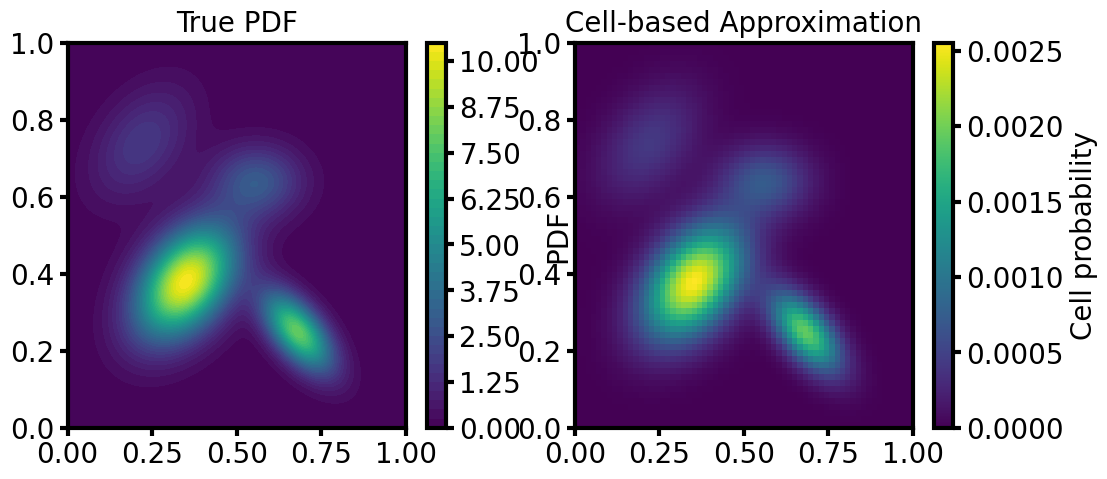

In [6]:
# --- Plot true PDF ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), levels=50, cmap='viridis')
plt.colorbar(label='PDF')
plt.title('True PDF')

# --- Plot cell approximation ---
plt.subplot(1,2,2)
approx_grid = target_probs.reshape(num_cells_x, num_cells_y).T  # transpose for correct orientation
plt.imshow(approx_grid, extent=[0,1,0,1], origin='lower', cmap='viridis', interpolation='nearest', aspect='auto')
plt.colorbar(label='Cell probability')
plt.title('Cell-based Approximation')

plt.show()

In [7]:
print(target_probs)

[2.6143e-07 3.9964e-07 5.9339e-07 ... 2.0717e-14 7.1910e-15 2.8120e-15]


In [8]:
### So what this code does is estimating target measure empiricaly i.e sum of diracs and then matching those! i.e centroids

In [9]:
# --- Dynamics & simulation ---
dt_emp = 0.01 ### Choose as the time we want i.e f:[0,t] -> X with t = dt_emp*T
tsteps = 100001
dt = 0.01 #1/tsteps            
ud = .2 #* dt_emp * tsteps 

def step(xt, ut):
    return xt + dt * ut

# --- Initialize ---
xt = np.random.uniform(low=0.0, high=1.0, size=(2,))
xt = np.array([.5,.5])
x_traj = np.zeros((tsteps, 2))
traj_counts = np.zeros_like(target_probs)
metric_log = []
divergence = []
# --- Main loop ---
for t in range(tsteps):
    # 1. Update trajectory counts
    ix = np.searchsorted(x_edges, xt[0], side='right') - 1
    iy = np.searchsorted(y_edges, xt[1], side='right') - 1
    ix = np.clip(ix, 0, num_cells_x-1)
    iy = np.clip(iy, 0, num_cells_y-1)
    cell_idx = ix*num_cells_y + iy
    traj_counts[cell_idx] += dt
    #print(target_probs)
    # 2. Compute control direction
    lambda_g = traj_counts / (((t+1) * dt))
    #print(lambda_g.sum())
    sigma = 0.05  # optional influence radius for decay
    epsilon = 1e-6
    e = target_probs - lambda_g
    e = np.maximum(0, e)
    vectors = centroids - xt  # shape (num_cells, 2)

    #dist = np.sum(vectors**2, axis=1)**0.5
    
    dist2 = np.sum(vectors**2, axis=1)

    weights = np.exp(-dist2 / sigma)
    #weights1 = np.exp(-dist / sigma)
    
    direction = np.sum(e[:, np.newaxis] * weights[:, np.newaxis] * (vectors / dist2[:, np.newaxis]), axis=0) ## dist is squared here!
    
    #direction = np.sum(e[:, np.newaxis] * weights[:, np.newaxis] * (vectors), axis=0) # sigma**(-2) can be ignored tough, as it does not change size of vecs in relation to another
    
    #direction = np.sum(e[:, np.newaxis] * weights[:, np.newaxis] * (vectors / dist[:, np.newaxis]), axis=0)#### looks resonable make sure dist is not squared!
    ut = ud * direction / (np.linalg.norm(direction) + 1e-8)

    # 3. Step dynamics
    xt = step(xt, ut)
    x_traj[t] = xt.copy()

    # 4. Compute simple ergodic metric
    metric = np.sum((target_probs - lambda_g)**2)
    metric_log.append(metric)

    # Logging every 1000 steps
    if t % 10000 == 0 and t != 0:
        print(f"Step {t}, Position: {xt[:2]}, Metric: {metric:.5f}")  
        mu_samples = sample_from_pdf_2d(pdf, [0,1], [0,1], n_samples = x_traj[:t,:].shape[0])
        KL = im.kld(x_traj[:t,:],mu_samples, approach='metric')
        divergence.append(KL)
        print(KL, 'emp')



Step 10000, Position: [0.659  0.3414], Metric: 0.00029
0.982730249457564 emp
Step 20000, Position: [0.1862 0.8288], Metric: 0.00010
0.6398367906874156 emp
Step 30000, Position: [0.1782 0.5377], Metric: 0.00005
0.5341242473318428 emp
Step 40000, Position: [0.0852 0.5891], Metric: 0.00003
0.45810890723401276 emp
Step 50000, Position: [0.3699 0.4769], Metric: 0.00002
0.41548011883181557 emp
Step 60000, Position: [0.4929 0.4612], Metric: 0.00002
0.37972218610017183 emp
Step 70000, Position: [0.2858 0.4544], Metric: 0.00001
0.35953953677663053 emp
Step 80000, Position: [0.2636 0.6231], Metric: 0.00001
0.3508098720423527 emp
Step 90000, Position: [0.5338 0.6443], Metric: 0.00001
0.3407092189694929 emp
Step 100000, Position: [0.5028 0.6673], Metric: 0.00001
0.328002029226786 emp


In [10]:
print(x_edges.shape)

(65,)


In [11]:
np.save(rf"C:/Users/JP/Documents/TU Berlin/Ergodicity_clean/Experiments/Divergence_data/Finite_{num_k_dim}.npy", np.array(divergence))

2025-08-21 18:08:42,512 |  WARNING | legend.py:1323 | No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


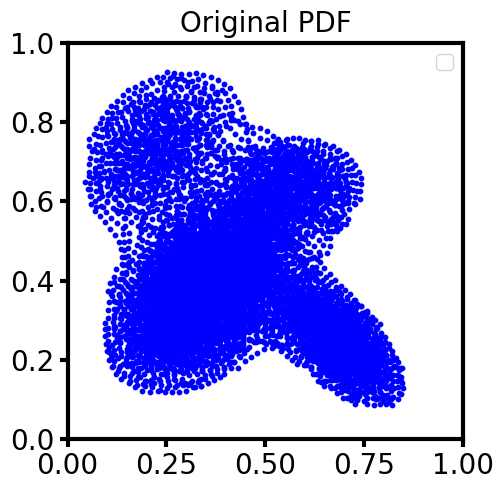

In [12]:
#mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
#ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.scatter(x_traj[::10, 0], x_traj[::10, 1], s=10, color='blue')
#ax.scatter(mu_samples[::10, 0], mu_samples[::10, 1], s=10, color='green')
ax.legend(loc=1)
plt.show()
plt.close()

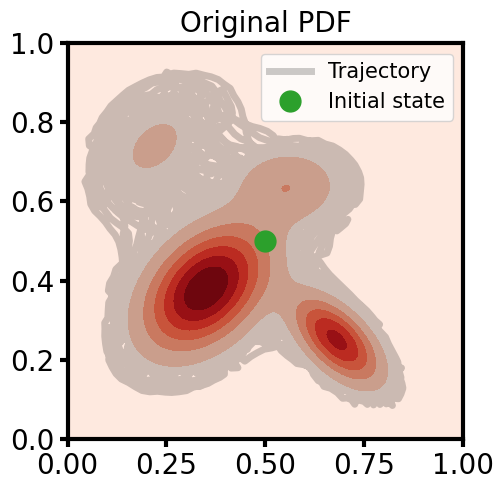

In [13]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
#ax.contourf(GX, GY, vals.reshape(ng, ng), cmap='Reds', alpha=0.6)
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds', alpha=1.)
ax.plot(x_traj[::10,0], x_traj[::10,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

plt.show()
plt.close()

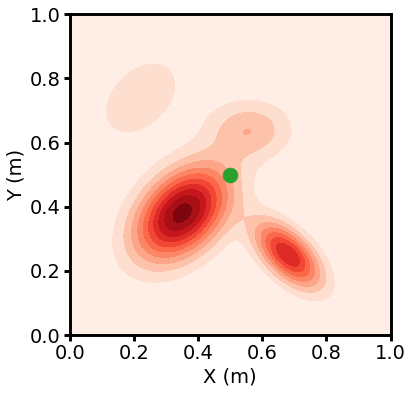

In [14]:
# Generate animation (takes about 1 minute)
from IPython.display import HTML
from matplotlib import animation

fig, ax = plt.subplots(1, 1, figsize=(6,7), dpi=70, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds', levels=10)

robot_traj, = ax.plot([], [], linestyle='-', marker='', color='k', alpha=0.2)
robot_state, = ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2')

def update_plot(frame):
    t = int(frame * 10)
    robot_state.set_data(
        np.array([x_traj[t][0]]), np.array([x_traj[t][1]])
    )
    robot_traj.set_data(
        x_traj[:t,0][::10], x_traj[:t,1][::10]
    )

    return robot_state, robot_traj,

#ani = animation.FuncAnimation(fig, update_plot, frames=int(tsteps/10)-1, blit=True, interval=30, repeat=False)
#video = ani.to_html5_video()
#HTML(video)